Group Name: Team Flash 

Students:
- Mohamed Radwan
- Mithunan Sivegnanam

In [115]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dat300-h2020-ca3/y_train_250.csv
/kaggle/input/dat300-h2020-ca3/sample_solution.csv
/kaggle/input/dat300-h2020-ca3/X_train_250.csv
/kaggle/input/dat300-h2020-ca3/X_test_100.csv


## Reading Data

In [116]:
def read_data():
    train_X = pd.read_csv('/kaggle/input/dat300-h2020-ca3/X_train_250.csv', chunksize=250000, iterator=True)
    train_y = pd.read_csv('/kaggle/input/dat300-h2020-ca3/y_train_250.csv', chunksize=250000, iterator=True)
    test_X = pd.read_csv('/kaggle/input/dat300-h2020-ca3/X_test_100.csv', chunksize=250000, iterator=True)
    
    return train_X, train_y, test_X
    
import time
start = time.time()
train_X, train_y, test_X = read_data()
stop = time.time()
print('Time spent here', stop-start)

Time spent here 0.0053784847259521484


## Scaling

In [117]:
from sklearn.preprocessing import StandardScaler
from scipy import stats
sc = StandardScaler()

start = time.time()

for batch in train_X:
    sc.partial_fit(batch)

stop = time.time()
print('Time spent here', stop-start)

Time spent here 95.22585892677307


## Classes Balance

In [118]:
labels_percent = []
idx = 1
for chunk in train_y:
    labels_percent.append((idx, chunk.target.value_counts(normalize=True)[0], chunk.target.value_counts(normalize=True)[1]))
    idx += 1

In [119]:
labels_percent[:5]

[(1, 0.994052, 0.005948),
 (2, 0.989276, 0.010724),
 (3, 0.989588, 0.010412),
 (4, 0.986436, 0.013564),
 (5, 0.985032, 0.014968)]

<Figure size 1440x720 with 0 Axes>

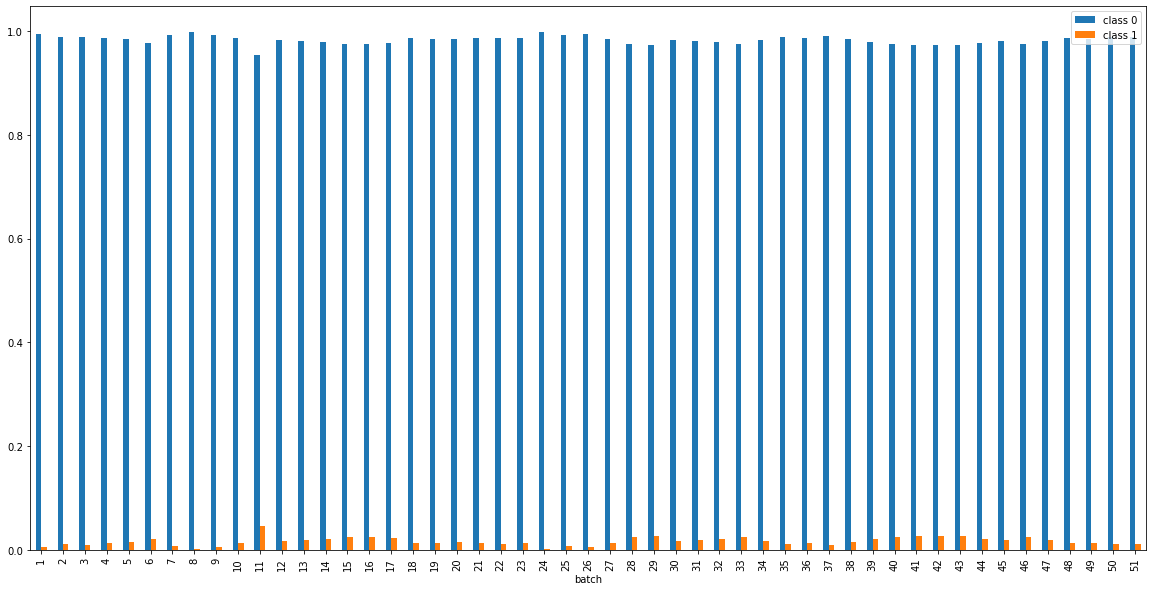

In [120]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
pd.DataFrame(labels_percent, columns=['batch','class 0', 'class 1']).set_index('batch').plot(kind='bar', figsize=(20,10));

The alove numbers show that the labels are extremly imbalanced in each chunk 

## Training

In [133]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, models
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization
from sklearn.metrics import fbeta_score
from keras import backend as K

print(tf.__version__)

def build_model():
    np.random.seed(42)
    tf.compat.v1.set_random_seed(42)
    model = models.Sequential([
                             Dense(64, activation=tf.nn.relu),
                             BatchNormalization(),
                             Dense(64, activation=tf.nn.relu),
                             BatchNormalization(),
                             Dense(64, activation=tf.nn.relu),
                             BatchNormalization(),
                             Dense(64, activation=tf.nn.relu),
                             BatchNormalization(),
                             Dense(64, activation=tf.nn.relu),
                             BatchNormalization(),
                             Dense(1, activation=tf.nn.sigmoid)])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0023))
    return model

2.3.1


#### This is the old oversampling and undersampling way of handling imbalance using imbalance-learn library, but we didn't use it, we used the class weights instead
    
    #!pip install imbalanced-learn
    #oversample = RandomOverSampler(sampling_strategy=0.5)
    #X, y = oversample.fit_resample(chunk_X, chunk_y)
    #undersample = RandomUnderSampler()
    #X, y = undersample.fit_resample(X, y)
    
- Undersampling and oversampling tends to give results that are baised towards the classes. Combination would be a relatively better choice.

- However, we used the class weights instead to weight the loss function differently. we assign between (80 : 100) to the classes 1. So for the loss function, each wrong predictions of class 1 will be as 80 or 100 times as wrong prediction of class 0. Looking at batch 1, Intuitively, the number of class 0 samples are 248513. The number of class 1 multiplied by 100 will give 148700 will will make it more balanced than it was before.  Plus, choice of 100:1 as a class weights will give a realistic results. Otherwise, we will end up with unrealitic 0.99 accuracies that only gives 0.8 accuracies at kaggle.
- We used the **train on batch** method from keras where the weights are updated incrementaly with each batch. for more details https://keras.io/api/models/model_training_apis/#trainonbatch-method


## Build validation data

In [122]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

#record time
start = time.time()

#initilize the valdiation data
X_val = None
y_val = None

#the data csv reader
train_X, train_y, test_X = read_data()

#this loop is mainly used to build the validation data
for chunk_X, chunk_y in zip(train_X, train_y):
    #train test split
    X = chunk_X
    y = chunk_y
    X_train, X_val_, y_train, y_val_ = train_test_split(X, y, test_size=0.02, random_state=42, stratify=y)   
    
    #build validation data, append each chunk validation to the validation lists above
    if X_val is None:
        X_val = X_val_.to_numpy()
    else:
        X_val = np.vstack((X_val, X_val_.to_numpy()))
    if y_val is None:
        y_val = y_val_.to_numpy().reshape(y_val_.shape[0], 1)
    else:
        y_val = np.vstack((y_val, y_val_.to_numpy().reshape(y_val_.shape[0], 1)))

stop = time.time()
print('Time spent here', stop-start)

Time spent here 166.88058638572693


## How many batches are enough?

In [123]:
#read the csv data
train_X, train_y, test_X = read_data()

#initilize the scores list
scores = []

#the model we will use for training
model = build_model()

"""
this loop is used only for training and monitoring the validation scores
this is to make sure we won't train on valiation data, since we train 
only on chunk that doesn't include validation data that we created earlier.
That's why we used the same seed here in train test split
"""
for chunk_X, chunk_y in zip(train_X, train_y):
    #train test split
    X = chunk_X
    y = chunk_y
    X_train, X_val_, y_train, y_val_ = train_test_split(X, y, test_size=0.02, random_state=42, stratify=y)   
    
    #training
    model.train_on_batch(sc.transform(X_train), y_train, class_weight={0: 1.,1: 100.})
    y_val_pred = model.predict(sc.transform(X_val))
    scores.append(f1_score(np.round(y_val_pred), y_val))

stop = time.time()
print('Time spent here', stop-start)

Time spent here 784.9586980342865


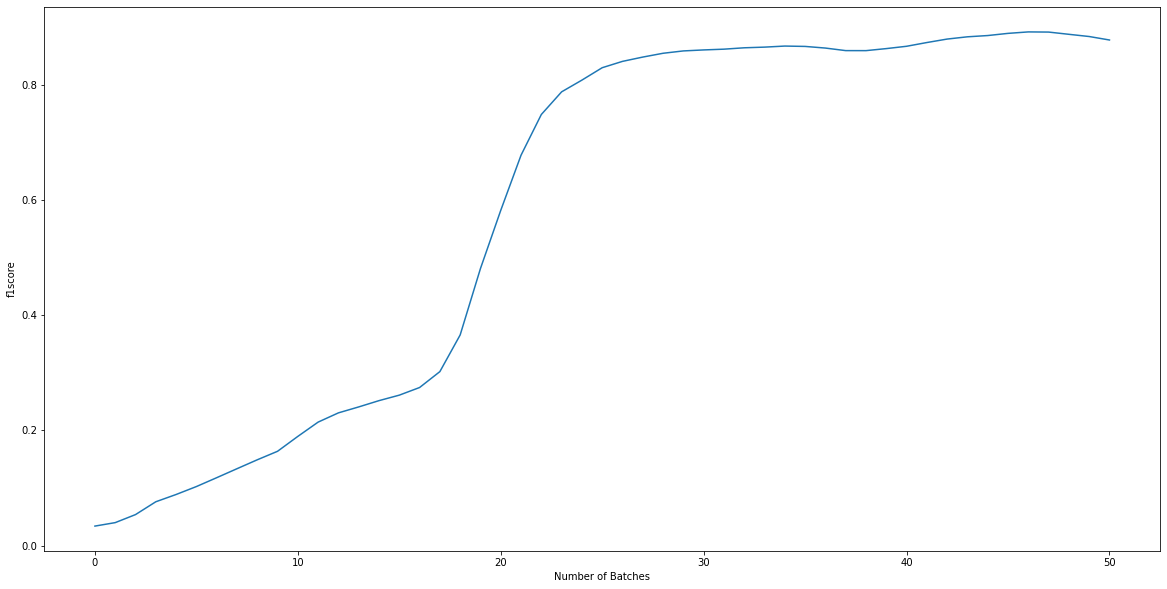

In [130]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.xlabel('Number of Batches')
plt.ylabel('f1score')
plt.plot(scores)
plt.show()

Looking at the validation accuracies, 30 batches would be enough for a low-compulationaly suboptimal results, 46 batches would gives best results

## Build the final model

In [135]:
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from scipy import stats


start = time.time()

final_model = build_model()

"""we chose only 2 epochs as the accuracies will decline 
after 2 epochs and also less computationaly intensive"""
for i in range(2):
    train_X, train_y, test_X = read_data()
    for chunk_X, chunk_y in zip(train_X, train_y):
        final_model.train_on_batch(sc.transform(chunk_X), chunk_y, class_weight={0: 1.,1: 100.})
    
    """This print only is to monitor 
    the accuracies while training each epoch.
    """
    y_val_pred = final_model.predict(sc.transform(X_val))
    print('F1 after epoch ', i+1, ':', f1_score(np.round(y_val_pred), y_val))

stop = time.time()
print('Time spent here', stop-start)

F1 after epoch  1 : 0.8746153846153847
F1 after epoch  2 : 0.9026059805452142
Time spent here 218.74949526786804


This final model achieves 0.90454 on kaggle, this means that the f1 scores here is more represenative to the public f1score in kaggle.


## Prediction and Submissions

Dealing with the test data as chuncks also and append the predictions of the chunks to the csv

In [136]:
import os
!rm submission.csv

size = 0

for batch in test_X:
    preds = final_model.predict_on_batch(sc.transform(batch))
    preds = np.round(preds).reshape(batch.shape[0],).astype(bool)
    submission = pd.DataFrame({'Predicted': preds})
    submission.index = submission.index + size
    submission.index.name = 'Id'
    if not os.path.isfile('submission.csv'):
        submission.to_csv('submission.csv', header=['Predicted'])
    else:
        submission.to_csv('submission.csv', mode='a', header=False)
    size += batch.shape[0]

In [137]:
#predictions class balance
sub = pd.read_csv('submission.csv')
count_0, count_1 = sub['Predicted'].value_counts()
print(count_0, count_1)

5008458 53042


## Refereneces

- Oliver Tomic and Kristin Liland, Applied Machine Learing DAT300, 2020